In [375]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
import random
random.seed(108448)

#%pip install gurobipy
import gurobipy as gp
from gurobipy import GRB

In [376]:
#Define the number of elememts in each set I, J, K
i_num = 10
k_num = 3
j_num = 115 #Without I and K, so real j_num_real = j_num + i_num + k_num

#Define empty data frames
I = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longtitude'])
J = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longtitude'])
K = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longtitude'])


In [377]:
#Define sets of I, J, K, where J contains I and K

for i in range(i_num):
    I.loc[i, 'Point number'] = 'i'+ str(i)
    I.loc[i, 'Latitude'] = round(random.uniform(0, 100), 4)
    I.loc[i, 'Longtitude'] = round(random.uniform(0, 100), 4)

I.index = I['Point number']
    
    
for k in range(k_num):
    K.loc[k, 'Point number'] = 'k'+ str(k)
    K.loc[k, 'Latitude'] = round(random.uniform(0, 100), 4)
    K.loc[k, 'Longtitude'] = round(random.uniform(0, 100), 4)

K.index = K['Point number']


for j in range(j_num):
    J.loc[j, 'Point number'] = 'j'+ str(j)
    J.loc[j, 'Latitude'] = round(random.uniform(0, 100), 4)
    J.loc[j, 'Longtitude'] = round(random.uniform(0, 100), 4)

J.index = J['Point number'] 
J = pd.concat([J, K], axis = 0) #Include K to J
J

,Point number,Latitude,Longtitude
Point number,,,
j0,j0,97.5091,95.9307
j1,j1,80.7738,80.9792
j2,j2,49.5597,43.5522
j3,j3,49.4614,64.1625
j4,j4,20.7972,48.2734
...,...,...,...
j113,j113,54.575,18.527
j114,j114,16.8562,43.867
k0,k0,42.7146,78.7246


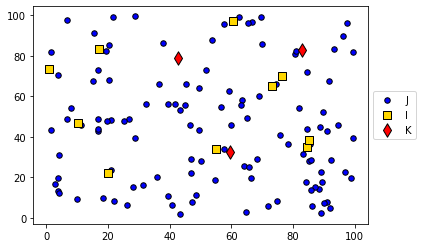

In [378]:
plt.scatter(J['Latitude'], J['Longtitude'], color = 'blue', edgecolors = 'black',
            marker = 'o', s = 30, label = 'J')
plt.scatter(I['Latitude'], I['Longtitude'], color = 'gold', edgecolors = 'black',
            marker = 's', s = 50, label = 'I')
plt.scatter(K['Latitude'], K['Longtitude'], color = 'red', edgecolors = 'black',
            marker = 'd', s = 90, label = 'K')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [379]:
#Define constants

B = 100
S = 50
alpha = 10000
beta = 400000
q = {j: 100 for j in J.index}
theta = {i: random.randint(0, 30) for i in I.index}
p = 0.97

theta

{'i0': 9,
 'i1': 24,
 'i2': 22,
 'i3': 8,
 'i4': 25,
 'i5': 16,
 'i6': 16,
 'i7': 17,
 'i8': 5,
 'i9': 11}

In [380]:
#Define distance matrices

def distance(point1, PointsSet1, point2, PointsSet2):
    c1 = np.array((PointsSet1.loc[point1, 'Latitude'], PointsSet1.loc[point1, 'Longtitude']))
    c2 = np.array((PointsSet2.loc[point2, 'Latitude'], PointsSet2.loc[point2, 'Longtitude']))
    return np.linalg.norm(c1-c2)

dist_JI = {(c1, c2): distance(c1, J, c2, I)for c1, c2 in itertools.product(J.index, I.index)}
dist_IK = {(c1, c2): distance(c1, I, c2, K)for c1, c2 in itertools.product(I.index, K.index)}
dist_KJ = {(c1, c2): distance(c1, K, c2, J)for c1, c2 in itertools.product(K.index, J.index)}
 
dist_IK


{('i0', 'k0'): 60.47572909663843,
 ('i0', 'k1'): 25.13115629532394,
 ('i0', 'k2'): 47.93433669531685,
 ('i1', 'k0'): 46.27443825277623,
 ('i1', 'k1'): 4.72887286781956,
 ('i1', 'k2'): 56.13783630636293,
 ('i2', 'k0'): 45.45669039261437,
 ('i2', 'k1'): 51.26959456402986,
 ('i2', 'k2'): 81.0692300456838,
 ('i3', 'k0'): 33.51637525702921,
 ('i3', 'k1'): 35.34267961685984,
 ('i3', 'k2'): 20.40449103555391,
 ('i4', 'k0'): 58.710604344530466,
 ('i4', 'k1'): 26.497431399477193,
 ('i4', 'k2'): 44.64300377718775,
 ('i5', 'k0'): 34.849955048608024,
 ('i5', 'k1'): 41.54874329170498,
 ('i5', 'k2'): 14.153883631003895,
 ('i6', 'k0'): 61.12939328948063,
 ('i6', 'k1'): 40.790876120157066,
 ('i6', 'k2'): 87.5603644595544,
 ('i7', 'k0'): 25.566853635322435,
 ('i7', 'k1'): 64.6156857806214,
 ('i7', 'k2'): 26.380077669711287,
 ('i8', 'k0'): 42.313227012956595,
 ('i8', 'k1'): 71.77110087730297,
 ('i8', 'k2'): 82.72973460914764,
 ('i9', 'k0'): 26.146438650416616,
 ('i9', 'k1'): 66.23263408056485,
 ('i9', '

In [381]:
#Define set L
L = list()
for k, j in itertools.product(K.index, J.index):
    if dist_KJ[(k, j)] <= 0.5*B:
        L.append((k, j))
        
L

[('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j9'),
 ('k0', 'j11'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j34'),
 ('k0', 'j37'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j48'),
 ('k0', 'j49'),
 ('k0', 'j50'),
 ('k0', 'j54'),
 ('k0', 'j56'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j63'),
 ('k0', 'j65'),
 ('k0', 'j66'),
 ('k0', 'j68'),
 ('k0', 'j72'),
 ('k0', 'j73'),
 ('k0', 'j75'),
 ('k0', 'j76'),
 ('k0', 'j77'),
 ('k0', 'j78'),
 ('k0', 'j79'),
 ('k0', 'j80'),
 ('k0', 'j81'),
 ('k0', 'j82'),
 ('k0', 'j85'),
 ('k0', 'j86'),
 ('k0', 'j89'),
 ('k0', 'j90'),
 ('k0', 'j92'),
 ('k0', 'j93'),
 ('k0', 'j95'),
 ('k0', 'j96'),
 ('k0', 'j97'),
 ('k0', 'j99'),
 ('k0', 'j100'),
 ('k0', 'j104'),
 ('k0', 'j107'),
 ('k0', 'j109'),
 ('k0', 'j110'),
 ('k0', 'j112'),
 ('k0', 'j114'),
 ('k0', 'k0'),
 ('k0', 'k1'),
 ('k0', 'k2'),
 ('k1', 'j2'),
 ('k1', 'j3'),
 ('k1', 'j4'),
 ('k1', 'j5'),
 ('k1', 'j7')

In [382]:
#Define sets M_kj

M_kj = {}
M_interim = []

for (k, j) in L:
    for i in I.index:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                M_interim.append(i)
    M_kj[(k, j)] = M_interim
    M_interim = []
  
M_kj  

{('k0', 'j1'): ['i3', 'i5', 'i7'],
 ('k0', 'j2'): ['i1'],
 ('k0', 'j3'): ['i1', 'i3', 'i5', 'i7', 'i9'],
 ('k0', 'j4'): ['i2', 'i9'],
 ('k0', 'j9'): ['i2', 'i9'],
 ('k0', 'j11'): ['i1', 'i2', 'i3', 'i5', 'i7', 'i8', 'i9'],
 ('k0', 'j21'): ['i3', 'i5', 'i7'],
 ('k0', 'j22'): ['i3', 'i5', 'i7'],
 ('k0', 'j24'): [],
 ('k0', 'j25'): ['i3', 'i5', 'i7'],
 ('k0', 'j30'): ['i5', 'i7'],
 ('k0', 'j31'): ['i3', 'i5', 'i7'],
 ('k0', 'j32'): ['i9'],
 ('k0', 'j34'): ['i2'],
 ('k0', 'j37'): ['i1', 'i3'],
 ('k0', 'j41'): ['i1', 'i3', 'i5', 'i7'],
 ('k0', 'j42'): ['i3', 'i5'],
 ('k0', 'j48'): ['i1', 'i2', 'i3', 'i5', 'i7', 'i9'],
 ('k0', 'j49'): ['i7', 'i8', 'i9'],
 ('k0', 'j50'): ['i7', 'i8', 'i9'],
 ('k0', 'j54'): ['i8', 'i9'],
 ('k0', 'j56'): ['i2', 'i8', 'i9'],
 ('k0', 'j59'): ['i2', 'i9'],
 ('k0', 'j60'): ['i8', 'i9'],
 ('k0', 'j63'): ['i3', 'i5', 'i7', 'i9'],
 ('k0', 'j65'): ['i7', 'i9'],
 ('k0', 'j66'): ['i2', 'i8', 'i9'],
 ('k0', 'j68'): ['i2', 'i8', 'i9'],
 ('k0', 'j72'): ['i3', 'i5', 'i7'],
 

In [383]:
#Define sets N_i

N_i = {}
N_interim = []

for i in I.index:
    for (k, j) in L:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                N_interim.append((k, j))
    N_i[i] = N_interim
    N_interim = []
    
N_i

{'i0': [('k1', 'j2'),
  ('k1', 'j7'),
  ('k1', 'j8'),
  ('k1', 'j10'),
  ('k1', 'j13'),
  ('k1', 'j14'),
  ('k1', 'j15'),
  ('k1', 'j16'),
  ('k1', 'j18'),
  ('k1', 'j19'),
  ('k1', 'j20'),
  ('k1', 'j21'),
  ('k1', 'j22'),
  ('k1', 'j26'),
  ('k1', 'j27'),
  ('k1', 'j28'),
  ('k1', 'j33'),
  ('k1', 'j35'),
  ('k1', 'j36'),
  ('k1', 'j37'),
  ('k1', 'j38'),
  ('k1', 'j39'),
  ('k1', 'j41'),
  ('k1', 'j45'),
  ('k1', 'j47'),
  ('k1', 'j52'),
  ('k1', 'j55'),
  ('k1', 'j58'),
  ('k1', 'j71'),
  ('k1', 'j74'),
  ('k1', 'j77'),
  ('k1', 'j79'),
  ('k1', 'j80'),
  ('k1', 'j82'),
  ('k1', 'j83'),
  ('k1', 'j84'),
  ('k1', 'j85'),
  ('k1', 'j86'),
  ('k1', 'j88'),
  ('k1', 'j94'),
  ('k1', 'j98'),
  ('k1', 'j100'),
  ('k1', 'j101'),
  ('k1', 'j102'),
  ('k1', 'j103'),
  ('k1', 'j104'),
  ('k1', 'j105'),
  ('k1', 'j106'),
  ('k1', 'j107'),
  ('k1', 'j108'),
  ('k1', 'j109'),
  ('k1', 'j113'),
  ('k1', 'k1'),
  ('k2', 'j1'),
  ('k2', 'j10'),
  ('k2', 'j26'),
  ('k2', 'j42'),
  ('k2', 'j53'),
  

In [384]:
model1 = gp.Model('Location-allocation problem 1')

In [385]:
x_ikj = model1.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model1.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')

In [386]:
model1.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i]) >= theta[i] for i in I.index), name = 'c2')
model1.addConstrs((gp.quicksum(x_ikj[i, k, j] for i in M_kj[(k, j)]) <= q[j] * y_j[j] for (k, j) in L), name = 'c4')
model1.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * y_j[j] <= B
                  for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c5')
model1.addConstrs((dist_JI[(j, i)] * y_j[j] <= S for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c6')

{('k0', 'j3', 'i1'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j3', 'i3'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j3', 'i5'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j3', 'i7'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j3', 'i9'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j4', 'i2'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j4', 'i9'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j9', 'i2'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j9', 'i9'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j11', 'i1'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j11', 'i2'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j11', 'i3'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j11', 'i5'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j11', 'i7'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j11', 'i8'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j11', 'i9'): <gurobi.Constr *Awaiting Model Update*>,
 

In [387]:
model1.setObjective(alpha * gp.quicksum(x_ikj) + beta * gp.quicksum(y_j), GRB.MINIMIZE)

In [388]:
model1.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 406 rows, 1958 columns and 1506 nonzeros
Model fingerprint: 0xcabbcf97
Variable types: 0 continuous, 1958 integer (118 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+04, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+00, 1e+02]
Found heuristic solution: objective 5130000.0000
Presolve removed 220 rows and 1292 columns
Presolve time: 0.01s
Presolved: 186 rows, 666 columns, 1286 nonzeros
Variable types: 0 continuous, 666 integer (111 binary)

Root relaxation: objective 1.886316e+06, 413 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

 

In [392]:
nSolutions = model1.SolCount
print('Number of solutions found: ' + str(nSolutions))
#for e in range(nSolutions):
for iter2 in range(1):
        model1.setParam(GRB.Param.SolutionNumber, iter2)
        print('%g ' % model1.PoolObjVal, end='\n')
        for v in model1.getVars():
             if v.xn > 0:
                   print ('%s %g' % (v.varName, v.Xn))
        print("\n")
print("\n")

Number of solutions found: 5
2.33e+06 
x_ikj[i0,k1,j37] 9
x_ikj[i1,k0,j37] 24
x_ikj[i2,k0,k0] 22
x_ikj[i3,k1,j37] 8
x_ikj[i4,k1,j37] 25
x_ikj[i5,k1,j37] 16
x_ikj[i6,k1,j37] 16
x_ikj[i7,k0,k0] 4
x_ikj[i7,k2,k0] 13
x_ikj[i8,k0,k0] 5
x_ikj[i9,k0,k0] 11
y_j[j37] 1
y_j[k0] 1






In [412]:
for v in model1.getVars():
    if v.xn > 0:
        if v.varName.startswith('x_ikj'):
            print(v.varName)

x_ikj[i0,k1,j37]
x_ikj[i1,k0,j37]
x_ikj[i2,k0,k0]
x_ikj[i3,k1,j37]
x_ikj[i4,k1,j37]
x_ikj[i5,k1,j37]
x_ikj[i6,k1,j37]
x_ikj[i7,k0,k0]
x_ikj[i7,k2,k0]
x_ikj[i8,k0,k0]
x_ikj[i9,k0,k0]
